<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/%EA%B5%B0%EC%A7%91%ED%99%94_%EC%8B%A4%EC%8A%B5%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 06 군집화 실습 - 고객 세그먼테이션

### 고객 세그먼테이션의 정의와 기법

고객 세그먼테이션 : 다양한 기준으로 고객을 분류하는 기법, CRM이나 마케팅의 중요 기반 요소

- 주요 목표

타깃 마케팅 : 고객을 여러 특성에 맞게 세분화해서 그 유형에 따라 맞춤형 마케팅이나 서비스를 제공하는 것.

-어떤 요소를 기반으로 군집화?

고객 분석 요소인 RFM 기법 이용

RECENCY : 가장 최근 상품 구입 일에서 오늘까지의 기간

FREQUENCY : 상품 구매 횟수

MONETARY VALUE : 총 구매 금액



In [32]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive')


retail_df=pd.read_excel('/content/drive/MyDrive/ESAA_YB/Online Retail.xlsx')

retail_df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


* invoiceNo: 주문번호
* stockcode: 제품코드
* description : 제품 설명
* quantity: 주문 제품 건수
* invoiceDate: 주문일자
* unitprice : 제품 단가
* customerid : 고객 번호
* country: 국가명

In [33]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


-> null 값이 너무 많다. 다른 칼럼도 오류 데이터가 존재한다. 데이터 전처리가 필요해 보임.

* Null 데이터 제거: 특히 customerID가 null인 데이터가 많음. 고객 세그먼테이션을 수행하므로 고객 식별번호가 없는 데이터는 필요가 없기에 삭제함.

* 오류 데이터 삭제:  대포적인 오류 데이터는 quantity 또는 unitprice가 0보다 작은 경우

In [34]:
retail_df=retail_df[retail_df['Quantity']>0]
retail_df=retail_df[retail_df['UnitPrice']>0]
retail_df=retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [35]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

In [36]:
#영국이 대다수를 차지하므로 다른 국가의 데이터 모두 제외
retail_df=retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


### RFM 기반 데이터 가공 

In [37]:
# 주문 금액 데이터 만들기
retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
#INT형으로 변경
retail_df['CustomerID']=retail_df['CustomerID'].astype(int)

<ipython-input-37-5408e06177d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['sale_amount']=retail_df['Quantity']*retail_df['UnitPrice']
<ipython-input-37-5408e06177d5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retail_df['CustomerID']=retail_df['CustomerID'].astype(int)


In [38]:
#top 5 주문 건수와 주문 금액을 가진 고객 데이터 추출
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


-> 몇몇 특정 고객이 많은 주문 건수와 주문 금액을 가지고 있음.

온라인 판매 데이터 세트는 전형적인 판매 데이터 세트와 같이 주문 번호 + 상품 코드 레벨의 식별자로 돼있음

In [39]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

-> 거의 1에 가깝게 유일한 식별자 레벨이 됨.

---------------------------
RFM 기반의 고객 세그먼테이션은 고객 레벨로 주문 기간, 주문횟수, 주문 금액 데이터를 기반으로 해 세그먼테이션을 수행하는 것이다.

이에 주문번호_상품코드 기준의 데이터를 고객 기준으 r, f, m 데이터로 변경 -> 주문 번호 기준의 데이터를 개별 고객 기준의 데이터로 group by해야함



In [40]:
#DataFrame의 groupby()의 multiple 연산을 위해 agg() 이용
#Recency는 InvoiceDate 칼럼의 max()에서 데이터 가공
#Frequency는 InvoiceNo 칼럼의 count(), Monetary value는 sale_amount 칼럼의 sum()
aggregations={
    'InvoiceDate':'max',
    'InvoiceNo':'count',
    'sale_amount':'sum'
}
cust_df=retail_df.groupby('CustomerID').agg(aggregations)
#groupby된 결과 컬럼 값을 Recency, Frequency, Monetary로 변경
cust_df=cust_df.rename(columns={'InvoiceDate':'Recency',
                                'InvoiceNo':'Frequency',
                                'sale_amount':'Monetary'})
     

cust_df=cust_df.reset_index()
cust_df.head(3)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73


-> Recency칼럼은 개별 고객당 가장 최근의 주문인데, 데이터 값의 특성으로 인해 아직 데이터 가공이 추가로 필요함. 

In [41]:
#오늘 날짜는 12.10로 하고 가장최근의 주문 일자를 뺀 데이터에서 일자 데이터만 추출해 생성

import datetime as dt

cust_df['Recency']=dt.datetime(2011,12,10)-cust_df['Recency']
cust_df['Recency']=cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 칼럼 건수는',cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73


### RFM 기반 고객 세그먼테이션

왜곡된 데이터 분포도를 가지게 되면 군집화가 한쪽 군집에만 집중되는 현상이 발생함. 

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <a list of 10 Patch objects>)

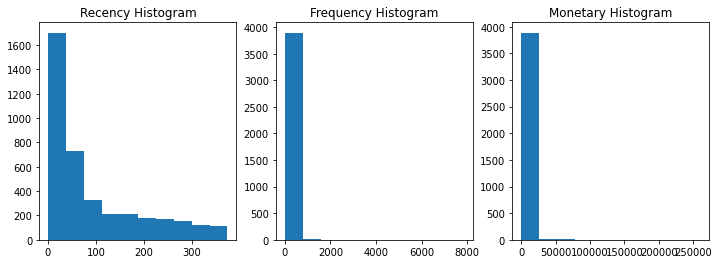

In [42]:
#먼저 온라인 판매 데이터 세트의 칼럼별 히스토그램을 확인
fig, (ax1,ax2,ax3)=plt.subplots(figsize=(12,4),nrows=1,ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

In [43]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


-> 왜곡된 정도가 매우 높은 데이터세트에 k-평균 군집을 적용하면 중심의 개수를 증가시키더라도 변별력이 떨어지는 군집화가 수행됨.

In [44]:
#데이터 세트를 평균과 표준편차를 재조정한 뒤 k-평균 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features=cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))


실루엣 스코어는 : 0.592


-> 군집을 3개로 구성할 경우 전체 군집의 평균 실루엣 계수인 실루엣 스코어는 0.592로 안정적인 수치가 나옴. 



In [45]:
# 군집별 실루엣 계수 값 보기

#군집 개수별로 군집화 구성을 시각화하는 함수
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    n_cols = len(cluster_lists)

    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    for ind, n_cluster in enumerate(cluster_lists):

        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

  

In [46]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

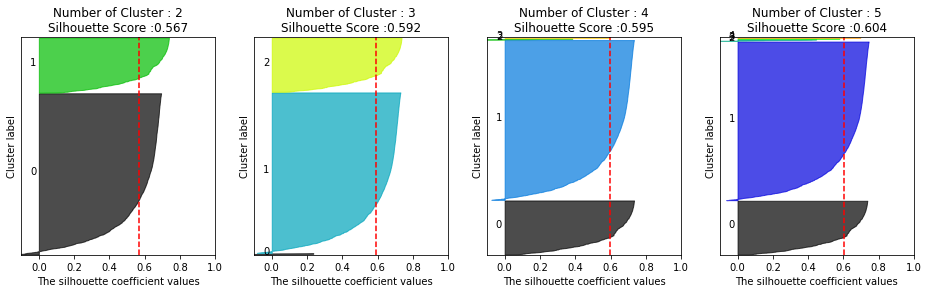

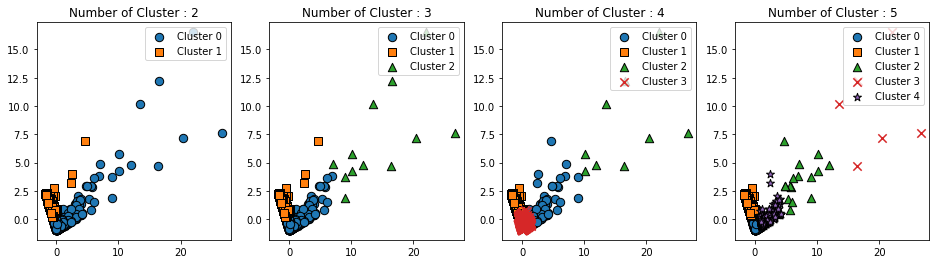

In [47]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

-> 군집이 2개일 경우 0번 군집과 1번 군집이 너무 개괄적으로 군집화되어있음. 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어진다. 
이처럼 지나치게 왜곡된 데이터 세트는 k-평균과 같은 거리 기반 군집화 알고리즘에서 지나치게 일반적이 ㄴ군집화 결과를 도출하게 된다.


In [48]:
#로그변환을 한 뒤에 k-평균 알고리즘 적용
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

#Recency, Frequency, Monetary 칼럼에 np.log1p()로 Log Transformation
cust_df['Recency_log']=np.log1p(cust_df['Recency'])
cust_df['Frequency_log']=np.log1p(cust_df['Frequency'])
cust_df['Monetary_log']=np.log1p(cust_df['Monetary'])

#Log Transformation 데이터에 StandardScaler 적용
X_features=cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled=StandardScaler().fit_transform(X_features)

kmeans=KMeans(n_clusters=3,random_state=0)
labels=kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label']=labels
print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.303


-> 로그 변환하기 전보다 떨어진다. 하지만 실루엣 스코어의 절대치가 중요한 것이 아니다. 어떻게 개별 군집이 더 균일하게 나뉠 수 있는지가 중요함.